In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, scipy.spatial, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 3)

[&larr; Back to Index](index.html)

# Dynamic Time Warping 

In MIR, we often want to compare two sequences of different lengths. For example, we may want to compute a similarity measure between two versions of the same song. These two signals, $x$ and $y$, may have similar sequences of chord progressions and instrumentations, but there may be timing deviations between the two. Even if we were to express the two audio signals using the same feature space (e.g. chroma or MFCCs), we cannot simply sum their pairwise distances because the signals have different lengths.

As another example, you might want to align two different performances of the same musical work, e.g. so you can hop from one performance to another at any moment in the work. This problem is known as **music synchronization** (FMP, p. 115).

**Dynamic time warping (DTW)** ([Wikipedia](https://en.wikipedia.org/wiki/Dynamic_time_warping); FMP, p. 131) is an algorithm used to align two sequences of similar content but possibly different lengths. 

Given two sequences, $x[n], n \in \{0, ..., N_x - 1\}$, and $y[n], n \in \{0, ..., N_y - 1\}$, DTW produces a set of index coordinate pairs $\{ (i, j) ... \}$ such that $x[i]$ and $y[j]$ are similar.

We will use the same dynamic programming approach described in the notebooks [Dynamic Programming](dp.html) and [Longest Common Subsequence](lcs.html).

## Example

Create two arrays, $x$ and $y$, of lengths $N_x$ and $N_y$, respectively.

In [2]:
x = [0, 4, 4, 0, -4, -4, 0]
y = [1, 3, 4, 3, 1, -1, -2, -1, 0]
nx = len(x)
ny = len(y)

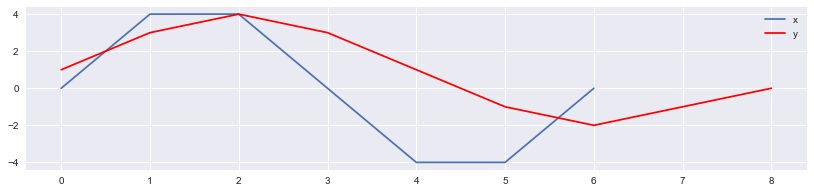

In [3]:
plt.plot(x)
plt.plot(y, c='r')
plt.legend(('x', 'y'))

In this simple example, there is only one value or "feature" at each time index. However, in practice, you can use sequences of *vectors*, e.g. spectrograms, chromagrams, or MFCC-grams.

## Distance Metric

DTW requires the use of a distance metric between corresponding observations of `x` and `y`. One common choice is the **Euclidean distance** ([Wikipedia](https://en.wikipedia.org/wiki/Euclidean_distance); FMP, p. 454):

In [4]:
scipy.spatial.distance.euclidean(0, [3, 4])

5.0

In [5]:
scipy.spatial.distance.euclidean([0, 0], [5, 12])

13.0

Another choice is the **Manhattan or cityblock distance**:

In [6]:
scipy.spatial.distance.cityblock(0, [3, 4])

7

In [7]:
scipy.spatial.distance.cityblock([0, 0], [5, 12])

17

Another choice might be the **cosine distance** ([Wikipedia](https://en.wikipedia.org/wiki/Cosine_similarity); FMP, p. 376) which can be interpreted as the (normalized) angle between two vectors:

In [8]:
scipy.spatial.distance.cosine([1, 0], [100, 0])

0.0

In [9]:
scipy.spatial.distance.cosine([1, 0, 0], [0, 0, -1])

1.0

In [10]:
scipy.spatial.distance.cosine([1, 0], [-1, 0])

2.0

For more distance metrics, see [`scipy.spatial.distance`](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).

## Step 1: Cost Table Construction

As described in the notebooks [Dynamic Programming](dp.html) and [Longest Common Subsequence](lcs.html), we will use dynamic programming to solve this problem. First, we create a table which stores the solutions to all subproblems. Then, we will use this table to solve each larger subproblem until the problem is solved for the full original inputs.

The basic idea of DTW is to find a path of index coordinate pairs the sum of distances along the path $P$ is minimized:

$$ \min \sum_{(i, j) \in P} d(x[i], y[j]) $$

The path constraint is that, at $(i, j)$, the valid steps are $(i+1, j)$, $(i, j+1)$, and $(i+1, j+1)$. In other words, the alignment always moves forward in time for at least one of the signals. It never goes forward in time for one signal and backward in time for the other signal.

Here is the optimal substructure. Suppose that the best alignment contains index pair `(i, j)`, i.e., `x[i]` and `y[j]` are part of the optimal DTW path. Then, we prepend to the optimal path 

$$ \mathrm{argmin} \ \{ d(x[i-1], y[j]), d(x[i], y[j-1]), d(x[i-1], j-1]) \} $$

We create a table where cell `(i, j)` stores the optimum cost of `dtw(x[:i], y[:j])`, i.e. the optimum cost from `(0, 0)` to `(i, j)`. First, we solve for the boundary cases, i.e. when either one of the two sequences is empty. Then we populate the table from the top left to the bottom right.

In [11]:
def dtw_table(x, y):
    nx = len(x)
    ny = len(y)
    table = numpy.zeros((nx+1, ny+1))
    
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = numpy.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = numpy.inf
        
    # Fill in the rest.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            d = scipy.spatial.distance.euclidean(x[i-1], y[j-1])
            table[i, j] = d + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table

In [12]:
table = dtw_table(x, y)

Let's visualize this table:

In [13]:
print('         ', ''.join('%4d' % n for n in y))
print('     +' + '----' * (ny+1))
for i, row in enumerate(table):
    if i == 0:
        z0 = ''
    else:
        z0 = x[i-1]
    print(('%4s |' % z0) + ''.join('%4.0f' % z for z in row))

             1   3   4   3   1  -1  -2  -1   0
     +----------------------------------------
     |   0 inf inf inf inf inf inf inf inf inf
   0 | inf   1   4   8  11  12  13  15  16  16
   4 | inf   4   2   2   3   6  11  17  20  20
   4 | inf   7   3   2   3   6  11  17  22  24
   0 | inf   8   6   6   5   4   5   7   8   8
  -4 | inf  13  13  14  12   9   7   7  10  12
  -4 | inf  18  20  21  19  14  10   9  10  14
   0 | inf  19  21  24  22  15  11  11  10  10


The time complexity of this operation is $O(N_x N_y)$. The space complexity is $O(N_x N_y)$.

## Step 2: Backtracking

To assemble the best path, we use **backtracking** (FMP, p. 139). We will start at the end, $(N_x - 1, N_y - 1)$, and backtrack to the beginning, $(0, 0)$.

Finally, just read off the sequences of time index pairs starting at the end.

In [14]:
def dtw(x, y, table):
    i = len(x)
    j = len(y)
    path = [(i, j)]
    while i > 0 or j > 0:
        minval = numpy.inf
        if table[i-1, j] < minval:
            minval = table[i-1, j]
            step = (i-1, j)
        if table[i][j-1] < minval:
            minval = table[i, j-1]
            step = (i, j-1)
        if table[i-1][j-1] < minval:
            minval = table[i-1, j-1]
            step = (i-1, j-1)
        path.insert(0, step)
        i, j = step
    return path

In [15]:
path = dtw(x, y, table)
path

[(0, 0),
 (1, 1),
 (2, 2),
 (2, 3),
 (3, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (5, 7),
 (6, 7),
 (7, 8),
 (7, 9)]

The time complexity of this operation is $O(N_x + N_y)$.

As a sanity check, compute the total distance of this alignment:

In [16]:
sum(abs(x[i-1] - y[j-1]) for (i, j) in path if i >= 0 and j >= 0)

10

Indeed, that is the same as the cumulative distance of the optimal path computed earlier:

In [17]:
table[-1, -1]

10.0

[&larr; Back to Index](index.html)